* During training, the generator is constantly trying to outsmart the discriminator by generating better and better fakes, while the discriminator is working to become a better detective and correctly classify the real and fake images. 

* The equilibrium of this game is when the generator is generating perfect fakes that look as if they came directly from the training data, and the discriminator is left to always guess at 50% confidence that the generator output is real or fake.4

![img.png](https://miro.medium.com/max/1250/1*6zMZBE6xtgGUVqkaLTBaJQ.png)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Dropout, Input ,LeakyReLU
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.datasets import mnist
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam

In [2]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [3]:
(X_train, y_train,X_test, y_test)=load_data()

In [4]:
X_train.shape, y_train.shape

((60000, 784), (60000,))

In [5]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

![img.png](https://miro.medium.com/max/875/1*Sqhji7Zz4IK2HDgCOabhXQ.png)

##### Creating generator

In [6]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator

In [7]:
g=create_generator()
g.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               8

We now create the Discriminator, Discriminator will take the input from real data which is of the size 784 and also the images generated from Generator

In [8]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator

In [9]:
d =create_discriminator()
d.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

* We now create the GAN where we combine the Generator and Discriminator. When we train the generator we will freeze the Discriminator.

* We will input the noised image of shape 100 units to the Generator. The output generated from the Generator will be fed to the Discriminator.

In [10]:
def create_gan(discriminator, generator):
    discriminator.trainable=False  # freezed the discriminator
    gan_input = Input(shape=(100,)) # gan input will be generator input dim
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

In [11]:
gan = create_gan(d,g)
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 784)               1486352   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


Before we start training the model, we will write a function plot_generated_images to plot the generated images. This way we can see how the images are generated. We save the generated images to file that we can view later

In [12]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

In [15]:
def training(epochs=1, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for batch_idx in tqdm(range(int(batch_count))):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            batch_start = batch_idx * batch_size
            image_batch = X_train[batch_start:(batch_start + batch_size)]
            
            #create batches of data that contain fake images from Generator and real images from the MNIST dataset 
            #that we will feed to Discriminator
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan.
            # This helps to check if our compiled models run fine on our real data as well as the noised data
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e %10 == 0:
           
            plot_generated_images(e, generator)

  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 1


  1%|▌                                                                                 | 3/468 [00:00<00:18, 25.63it/s]

Epoch 2


  1%|▋                                                                                 | 4/468 [00:00<00:16, 28.96it/s]

Epoch 3


  1%|█                                                                                 | 6/468 [00:00<00:16, 28.86it/s]

Epoch 4


  1%|▋                                                                                 | 4/468 [00:00<00:15, 30.55it/s]

Epoch 5


  1%|▋                                                                                 | 4/468 [00:00<00:16, 27.62it/s]

Epoch 6


  1%|▋                                                                                 | 4/468 [00:00<00:14, 32.94it/s]

Epoch 7


  1%|▌                                                                                 | 3/468 [00:00<00:15, 29.29it/s]

Epoch 8


  1%|▋                                                                                 | 4/468 [00:00<00:15, 30.65it/s]

Epoch 9


  1%|▋                                                                                 | 4/468 [00:00<00:14, 30.96it/s]

Epoch 10


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 11


  1%|▋                                                                                 | 4/468 [00:00<00:14, 32.35it/s]

Epoch 12


  1%|▋                                                                                 | 4/468 [00:00<00:15, 30.55it/s]

Epoch 13


  1%|▋                                                                                 | 4/468 [00:00<00:15, 30.75it/s]

Epoch 14


  1%|▋                                                                                 | 4/468 [00:00<00:14, 30.97it/s]

Epoch 15


  1%|▋                                                                                 | 4/468 [00:00<00:14, 31.72it/s]

Epoch 16


  1%|▋                                                                                 | 4/468 [00:00<00:14, 32.17it/s]

Epoch 17


  1%|▌                                                                                 | 3/468 [00:00<00:16, 28.99it/s]

Epoch 18


  1%|▋                                                                                 | 4/468 [00:00<00:14, 31.79it/s]

Epoch 19


  1%|▌                                                                                 | 3/468 [00:00<00:16, 27.43it/s]

Epoch 20


  1%|▋                                                                                 | 4/468 [00:00<00:15, 30.67it/s]

Epoch 21


  1%|▋                                                                                 | 4/468 [00:00<00:14, 31.71it/s]

Epoch 22


  1%|▋                                                                                 | 4/468 [00:00<00:15, 30.33it/s]

Epoch 23


  1%|▋                                                                                 | 4/468 [00:00<00:13, 34.43it/s]

Epoch 24


  1%|▋                                                                                 | 4/468 [00:00<00:12, 36.59it/s]

Epoch 25


  1%|▌                                                                                 | 3/468 [00:00<00:16, 27.44it/s]

Epoch 26


  1%|▋                                                                                 | 4/468 [00:00<00:14, 32.01it/s]

Epoch 27


  1%|▋                                                                                 | 4/468 [00:00<00:13, 34.14it/s]

Epoch 28


  1%|▋                                                                                 | 4/468 [00:00<00:14, 32.01it/s]

Epoch 29


  1%|▋                                                                                 | 4/468 [00:00<00:14, 32.01it/s]

Epoch 30


  1%|▋                                                                                 | 4/468 [00:00<00:15, 30.31it/s]

Epoch 31


  1%|▋                                                                                 | 4/468 [00:00<00:14, 32.02it/s]

Epoch 32


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 33


  0%|▎                                                                                 | 2/468 [00:00<00:39, 11.69it/s]

Epoch 34


  0%|▎                                                                                 | 2/468 [00:00<00:38, 12.17it/s]

Epoch 35


  0%|▏                                                                                 | 1/468 [00:00<00:46,  9.96it/s]

Epoch 36


  0%|▏                                                                                 | 1/468 [00:00<00:56,  8.28it/s]

Epoch 37


  0%|▎                                                                                 | 2/468 [00:00<00:35, 12.96it/s]

Epoch 38


  0%|▎                                                                                 | 2/468 [00:00<00:47,  9.90it/s]

Epoch 39


  0%|▎                                                                                 | 2/468 [00:00<00:44, 10.50it/s]

Epoch 40


  0%|▎                                                                                 | 2/468 [00:00<00:39, 11.81it/s]

Epoch 41


  0%|▏                                                                                 | 1/468 [00:00<00:52,  8.95it/s]

Epoch 42


  0%|▎                                                                                 | 2/468 [00:00<00:42, 11.07it/s]

Epoch 43


  0%|▏                                                                                 | 1/468 [00:00<00:50,  9.26it/s]

Epoch 44


  0%|▏                                                                                 | 1/468 [00:00<00:53,  8.80it/s]

Epoch 45


  0%|▎                                                                                 | 2/468 [00:00<00:44, 10.59it/s]

Epoch 46


  0%|▎                                                                                 | 2/468 [00:00<00:37, 12.59it/s]

Epoch 47


  0%|▎                                                                                 | 2/468 [00:00<00:37, 12.54it/s]

Epoch 48


  1%|▌                                                                                 | 3/468 [00:00<00:16, 27.43it/s]

Epoch 49


  1%|▌                                                                                 | 3/468 [00:00<00:15, 29.43it/s]

Epoch 50


  1%|▌                                                                                 | 3/468 [00:00<00:16, 27.72it/s]

Epoch 51


  1%|▌                                                                                 | 3/468 [00:00<00:16, 28.62it/s]

Epoch 52


  1%|▌                                                                                 | 3/468 [00:00<00:15, 29.36it/s]

Epoch 53


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 54


  1%|▋                                                                                 | 4/468 [00:00<00:15, 30.57it/s]

Epoch 55


  1%|▋                                                                                 | 4/468 [00:00<00:14, 32.01it/s]

Epoch 56


  1%|▌                                                                                 | 3/468 [00:00<00:16, 28.38it/s]

Epoch 57


  1%|▌                                                                                 | 3/468 [00:00<00:17, 26.81it/s]

Epoch 58


  1%|▋                                                                                 | 4/468 [00:00<00:14, 32.02it/s]

Epoch 59


  1%|▋                                                                                 | 4/468 [00:00<00:14, 31.42it/s]

Epoch 60


  1%|▌                                                                                 | 3/468 [00:00<00:16, 27.54it/s]

Epoch 61


  1%|▌                                                                                 | 3/468 [00:00<00:16, 27.44it/s]

Epoch 62


  1%|▋                                                                                 | 4/468 [00:00<00:15, 30.25it/s]

Epoch 63


  1%|▌                                                                                 | 3/468 [00:00<00:16, 27.43it/s]

Epoch 64


  1%|▌                                                                                 | 3/468 [00:00<00:16, 28.60it/s]

Epoch 65


  1%|▋                                                                                 | 4/468 [00:00<00:15, 30.52it/s]

Epoch 66


  1%|▋                                                                                 | 4/468 [00:00<00:14, 32.02it/s]

Epoch 67


  1%|▌                                                                                 | 3/468 [00:00<00:16, 27.94it/s]

Epoch 68


  1%|▌                                                                                 | 3/468 [00:00<00:19, 24.25it/s]

Epoch 69


  1%|▋                                                                                 | 4/468 [00:00<00:13, 34.31it/s]

Epoch 70


  1%|▋                                                                                 | 4/468 [00:00<00:14, 31.49it/s]

Epoch 71


  1%|▋                                                                                 | 4/468 [00:00<00:14, 32.01it/s]

Epoch 72


  1%|▋                                                                                 | 4/468 [00:00<00:14, 31.72it/s]

Epoch 73


  1%|▋                                                                                 | 4/468 [00:00<00:14, 31.02it/s]

Epoch 74


  1%|▌                                                                                 | 3/468 [00:00<00:17, 26.56it/s]

Epoch 75


  1%|▋                                                                                 | 4/468 [00:00<00:14, 32.00it/s]

Epoch 76


  1%|▌                                                                                 | 3/468 [00:00<00:17, 27.31it/s]

Epoch 77


  1%|▌                                                                                 | 3/468 [00:00<00:18, 24.82it/s]

Epoch 78


  1%|▋                                                                                 | 4/468 [00:00<00:14, 31.01it/s]

Epoch 79


  1%|▌                                                                                 | 3/468 [00:00<00:17, 27.05it/s]

Epoch 80


  1%|▌                                                                                 | 3/468 [00:00<00:16, 28.66it/s]

Epoch 81


  1%|▋                                                                                 | 4/468 [00:00<00:15, 30.64it/s]

Epoch 82


  0%|▎                                                                                 | 2/468 [00:00<00:29, 15.55it/s]

Epoch 83


  1%|▋                                                                                 | 4/468 [00:00<00:15, 30.79it/s]

Epoch 84


  1%|▋                                                                                 | 4/468 [00:00<00:15, 30.73it/s]

Epoch 85


  1%|▌                                                                                 | 3/468 [00:00<00:16, 28.75it/s]

Epoch 86


  1%|▋                                                                                 | 4/468 [00:00<00:14, 31.14it/s]

Epoch 87


  1%|▋                                                                                 | 4/468 [00:00<00:15, 29.79it/s]

Epoch 88


  1%|▌                                                                                 | 3/468 [00:00<00:16, 27.56it/s]

Epoch 89


  1%|▌                                                                                 | 3/468 [00:00<00:15, 29.13it/s]

Epoch 90


  1%|▌                                                                                 | 3/468 [00:00<00:17, 27.12it/s]

Epoch 91


  1%|▋                                                                                 | 4/468 [00:00<00:14, 32.01it/s]

Epoch 92


  1%|▋                                                                                 | 4/468 [00:00<00:14, 32.01it/s]

Epoch 93


  1%|▌                                                                                 | 3/468 [00:00<00:20, 22.56it/s]

Epoch 94


  1%|▋                                                                                 | 4/468 [00:00<00:14, 31.22it/s]

Epoch 95


  1%|▌                                                                                 | 3/468 [00:00<00:16, 28.47it/s]

Epoch 96


  1%|▌                                                                                 | 3/468 [00:00<00:18, 24.50it/s]

Epoch 97


  1%|█                                                                                 | 6/468 [00:00<00:15, 29.39it/s]

Epoch 98


  1%|▋                                                                                 | 4/468 [00:00<00:14, 31.37it/s]

Epoch 99


  1%|▋                                                                                 | 4/468 [00:00<00:15, 30.76it/s]

Epoch 100


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:16<00:00, 28.71it/s]


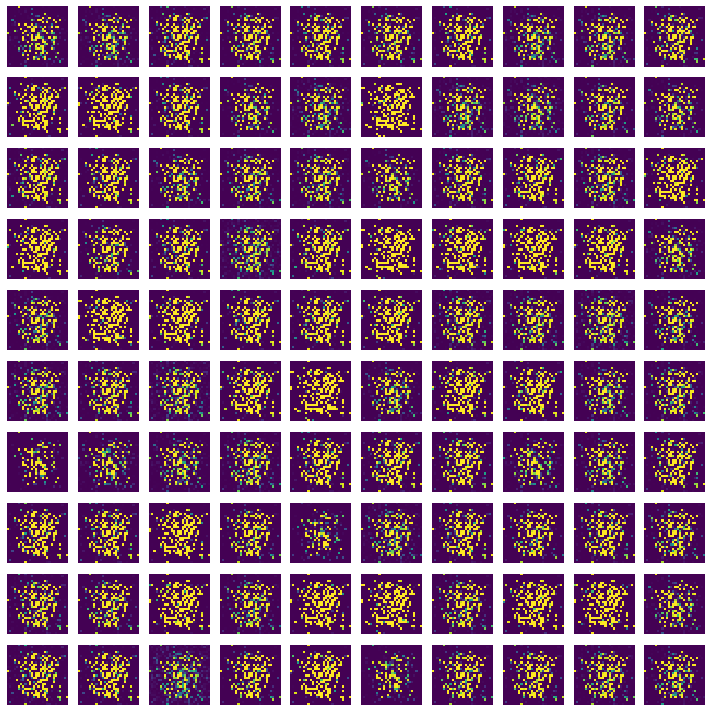

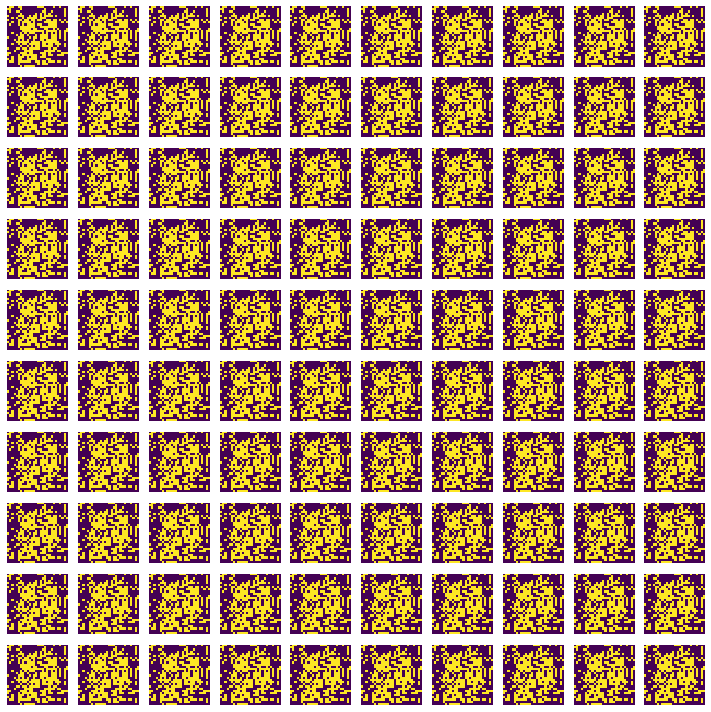

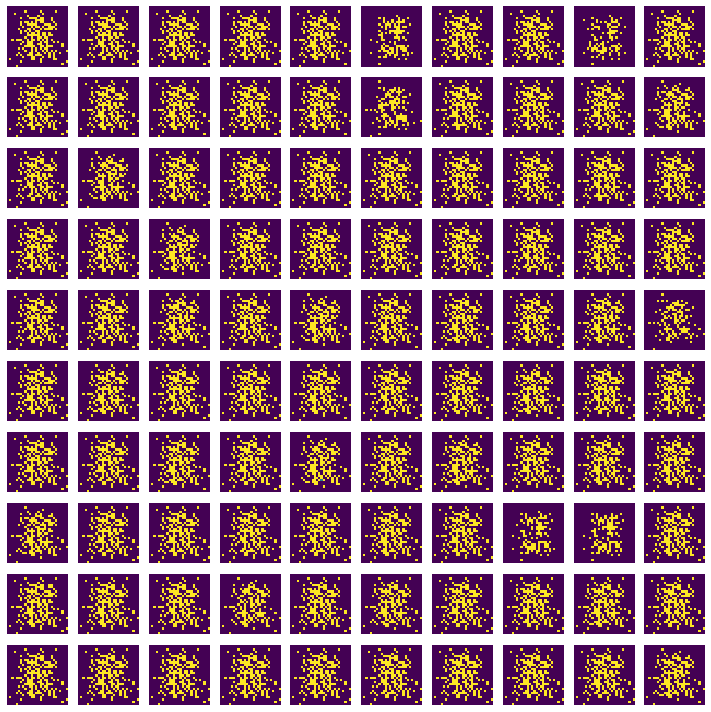

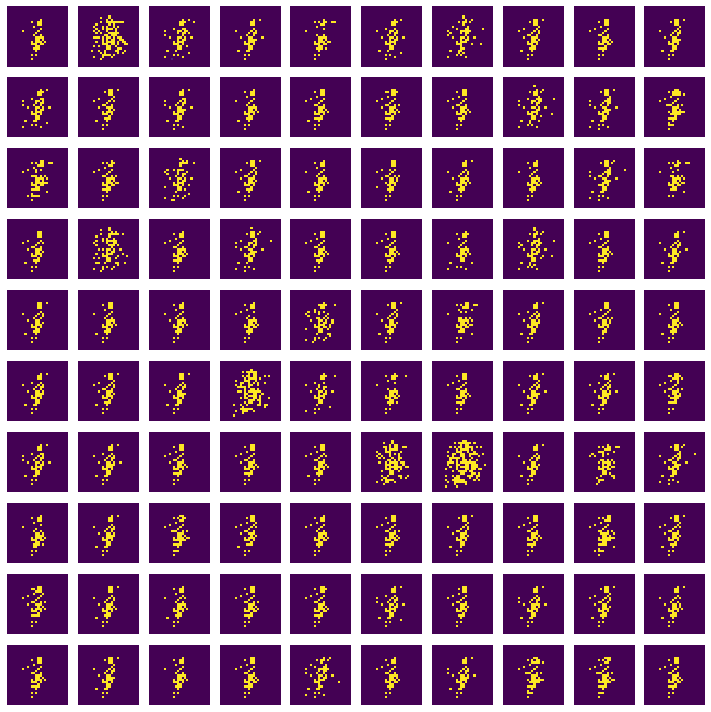

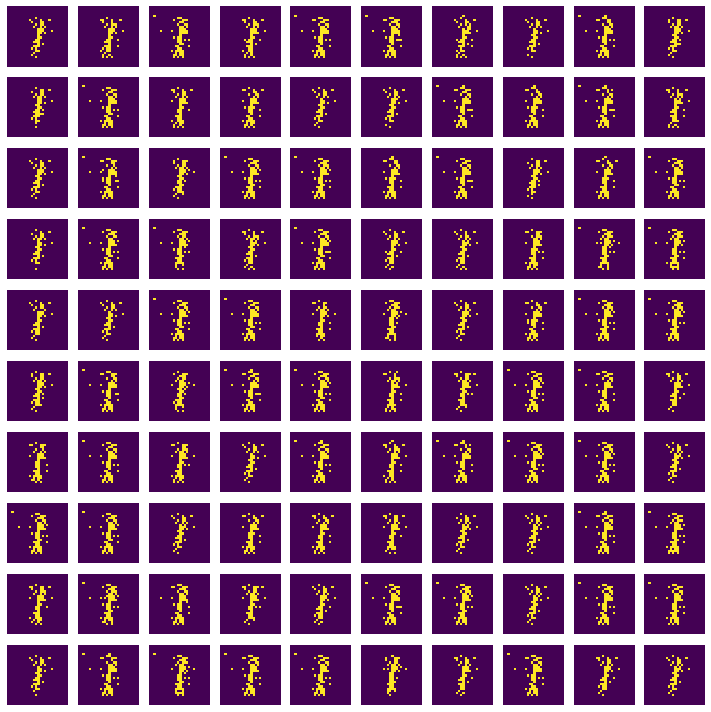

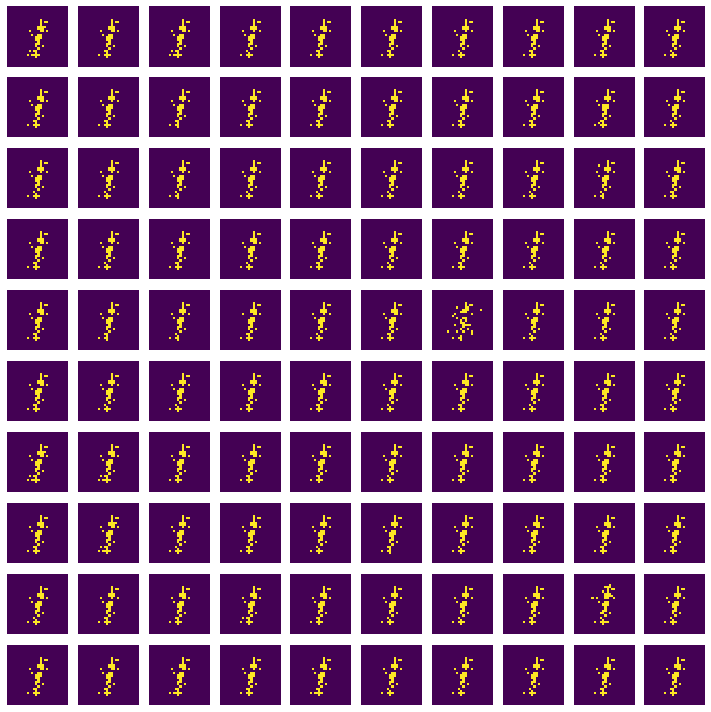

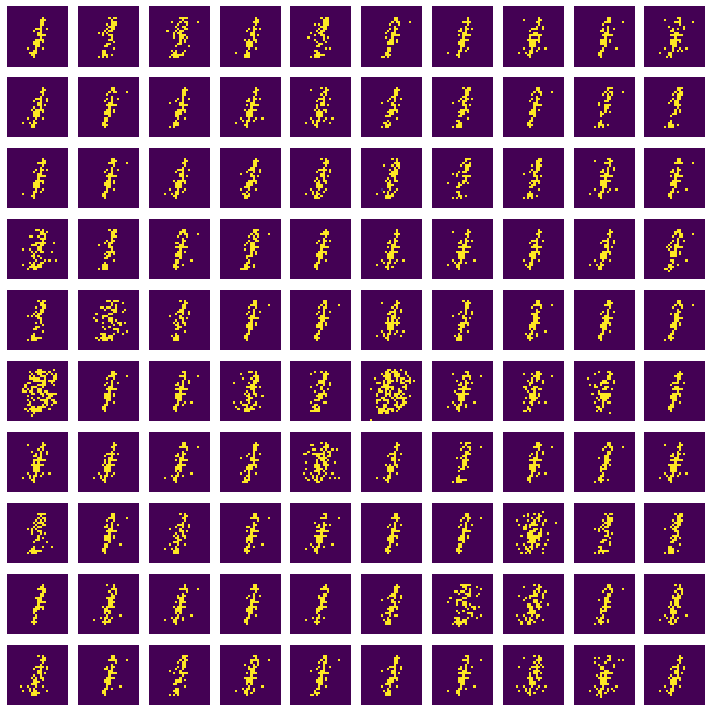

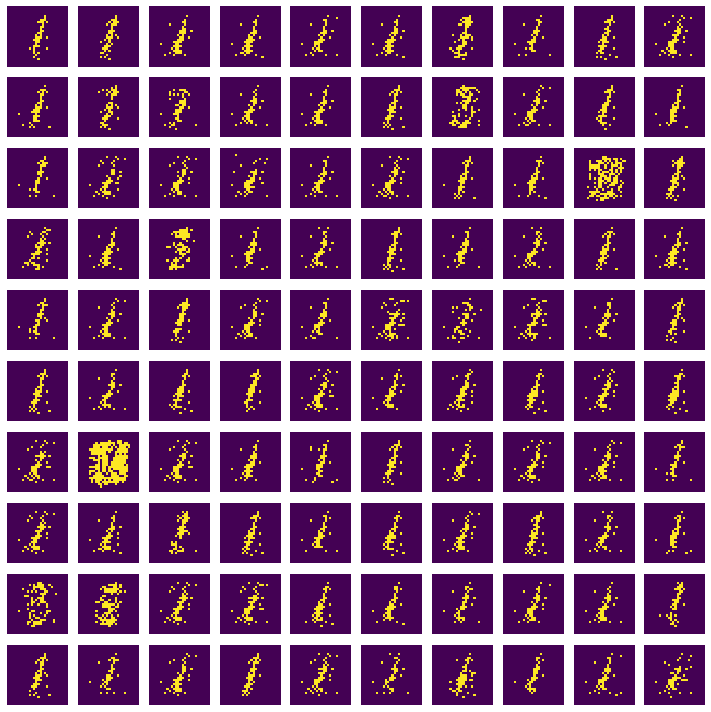

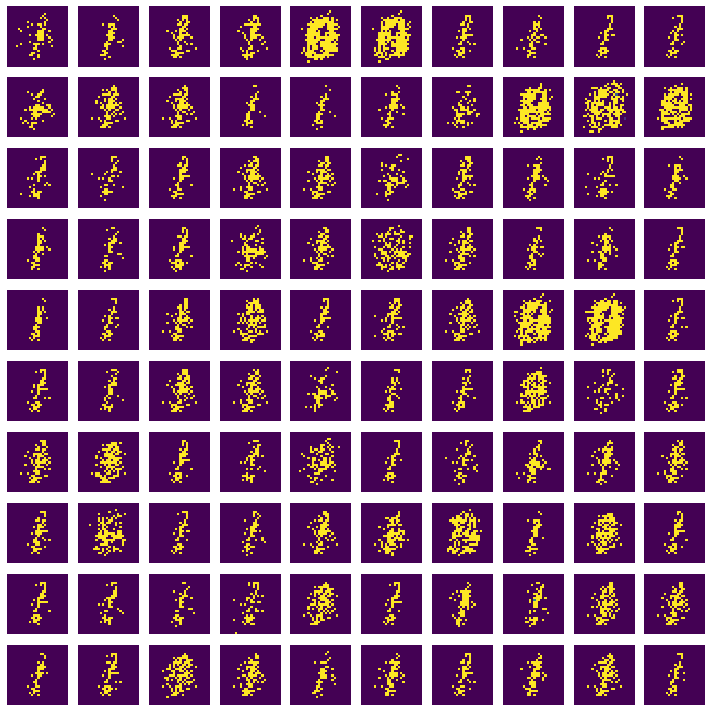

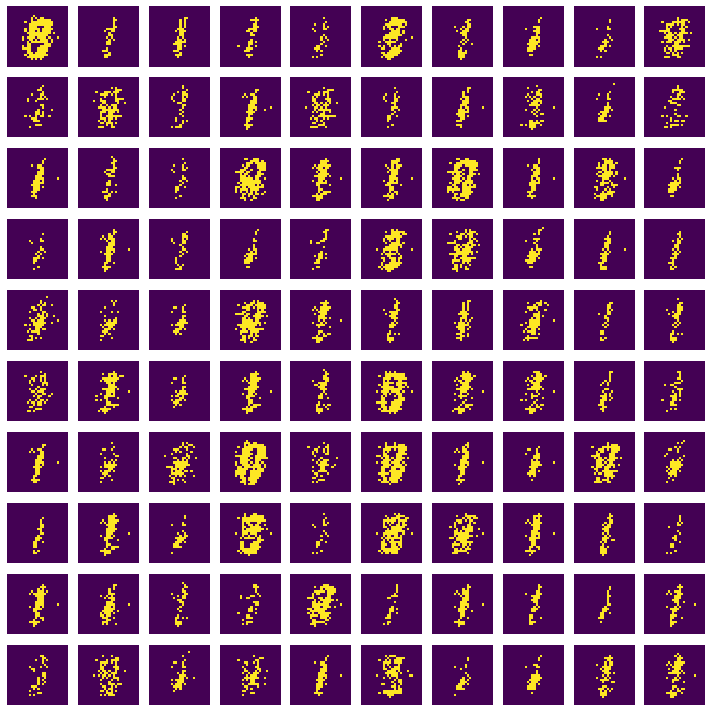

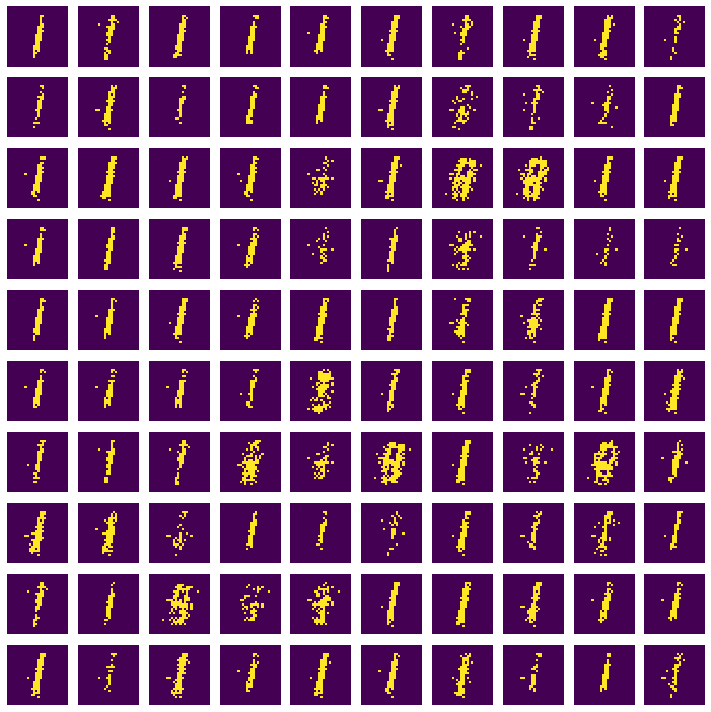

In [16]:
training(100,128)

#### NOTE :  TO get more accuracy we need to perform more epochs. 